In [1]:
import os
import cv2
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from datetime import datetime, timedelta
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from Dataset import *
from torchvision import transforms


In [2]:

# Function to parse video and extract frames around a specific timestamp
def extract_video_clip(video_path, target_timestamp, video_start_time,time_window=2):
    # Open the video
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error opening video: {video_path}")
        return None
    # Get video frame rate and total frame count
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the frame range for the +- time_window
    target_time = target_timestamp
    start_time = target_time - timedelta(seconds=time_window)
    end_time = target_time + timedelta(seconds=time_window)
    if start_time < video_start_time:
        start_time = video_start_time
    if end_time > video_start_time + timedelta(seconds=total_frames / fps):
        end_time = video_start_time + timedelta(seconds=total_frames / fps)
    # print(f"Target Time: {target_time}, Start Time: {start_time}, End Time: {end_time}")
    # Extract frames within the time range
    frames = []
    frame_index = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        # Calculate the timestamp for the current frame
        frame_time = video_start_time + timedelta(seconds=frame_index / fps)
        if start_time <= frame_time <= end_time:
            frames.append(frame)
        frame_index += 1
        if frame_time > end_time:
            break

    cap.release()
    return np.array(frames)

# Load Excel file
def load_excel_data(file_path):
    activation_df = pd.read_excel(file_path, sheet_name="Activation")
    non_activation_df = pd.read_excel(file_path, sheet_name="NonActivation")
    return activation_df, non_activation_df

# Function to process dataset and extract video clips
def process_dataset(video_dir, excel_file, output_dir, clip_save_dir, time_window=3):
    # Load the Excel data
    activation_df, non_activation_df = load_excel_data(excel_file)

    # Create directories for saving data
    os.makedirs(output_dir, exist_ok=True)
    train_dir = os.path.join(output_dir, "train")
    val_dir = os.path.join(output_dir, "val")
    test_dir = os.path.join(output_dir, "test")
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)
    os.makedirs(clip_save_dir, exist_ok=True)

    # Prepare data for activation and non-activation
    # all_data = []
    for df, label in [(activation_df, 1), (non_activation_df, 0)]:
        for _, row in tqdm(df.iterrows()):
            clip_timestamp = row["timestamp"]
            location = row["location"]
            # convert to datetime object
            clip_timestamp = datetime.strptime(clip_timestamp, "%Y%m%d_%H%M%S")
            # Match the video file with the timestamp
            for video_file in os.listdir(video_dir):
                video_start_timestamp = video_file[22:].split(".")[0]
                # convert to datetime object
                video_start_timestamp = datetime.strptime(video_start_timestamp, "%Y%m%d_%H%M%S")
                video_end_timestamp = video_start_timestamp + timedelta(seconds=60 * 5)
                if video_start_timestamp <= clip_timestamp <= video_end_timestamp:
                    video_path = os.path.join(video_dir, video_file)
                    clip_save_path = os.path.join(clip_save_dir, f"{label}_{row['timestamp']}_{location}.pt")
                    if os.path.exists(clip_save_path):
                        continue
                    # Extract video clip
                    frames = extract_video_clip(video_path, clip_timestamp, video_start_timestamp,time_window)
                    if frames is not None:
                        data = (frames, label, row["timestamp"], location)
                        # save the clip to the clip_save_dir
                        # clip_save_path = os.path.join(clip_save_dir, f"{label}_{row['timestamp']}_{location}.pt")
                        torch.save(torch.tensor(frames), clip_save_path)



In [5]:
# Process the dataset
video_dir = r"D:\LiDAR_Data\2ndPHB\Video\IntesectionVideo"
excel_file = r"D:\LiDAR_Data\2ndPHB\Video\Activation.xlsx"
output_dir = r"D:\LiDAR_Data\2ndPHB\Video\Dataset"
clip_save_dir = r"D:\LiDAR_Data\2ndPHB\Video\Clips"
time_window = 3 # seconds
# Load the Excel data
activation_df, non_activation_df = load_excel_data(excel_file)


In [96]:
video_dir = r"D:\LiDAR_Data\2ndPHB\Video\IntesectionVideo"
total_video_list = os.listdir(video_dir)
# video file format: 00_00_192.168.1.108_1_20241204_224500.avi
# activation record format: 20241204_224500
# identify the video files that are not in the excel file
total_record_list = activation_df["timestamp"].tolist() + non_activation_df["timestamp"].tolist()
# convert to timestamp
total_record_list = [datetime.strptime(record, "%Y%m%d_%H%M%S") for record in total_record_list]
total_record_list_ = []
for record in total_record_list:
    record = record - timedelta(minutes = record.minute % 5)
    record = record.replace(second = 0 )
    total_record_list_.append(record)
unique_record_list = list(set(total_record_list_))
unvisited_video_list = []
for video in total_video_list:
    video_start_timestamp = total_video_list[0][22:].split(".")[0]
    video_start_timestamp = datetime.strptime(video_start_timestamp, "%Y%m%d_%H%M%S")
    if video_start_timestamp not in unique_record_list:
        unvisited_video_list.append(video)



In [98]:
len(unvisited_video_list)

1236

In [89]:
record = total_record_list[92]
print(record)
record = record - timedelta(minutes = record.minute % 5)
# alternate the second to 0
record = record.replace(second = 0 )
print(record)

2024-12-08 13:51:04
2024-12-08 13:50:00


In [81]:
record

datetime.datetime(2024, 12, 6, 14, 40)

In [4]:
# Process the dataset
video_dir = r"D:\LiDAR_Data\2ndPHB\Video\IntesectionVideo"
excel_file = r"D:\LiDAR_Data\2ndPHB\Video\Activation.xlsx"
output_dir = r"D:\LiDAR_Data\2ndPHB\Video\Dataset"
clip_save_dir = r"D:\LiDAR_Data\2ndPHB\Video\Clips"
time_window = 3 # seconds
# Load the Excel data
activation_df, non_activation_df = load_excel_data(excel_file)

# Create directories for saving data
os.makedirs(output_dir, exist_ok=True)
train_dir = os.path.join(output_dir, "train")
val_dir = os.path.join(output_dir, "val")
test_dir = os.path.join(output_dir, "test")
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)
os.makedirs(clip_save_dir, exist_ok=True)

# Prepare data for activation and non-activation
# all_data = []
for df, label in [(activation_df, 1), (non_activation_df, 0)]:
    for _, row in tqdm(df.iterrows()):
        clip_timestamp = row["timestamp"]
        location = row["location"]
        # convert to datetime object
        clip_timestamp = datetime.strptime(clip_timestamp, "%Y%m%d_%H%M%S")
        # Match the video file with the timestamp
        for video_file in os.listdir(video_dir):
            video_start_timestamp = video_file[22:].split(".")[0]
            # convert to datetime object
            video_start_timestamp = datetime.strptime(video_start_timestamp, "%Y%m%d_%H%M%S")
            video_end_timestamp = video_start_timestamp + timedelta(seconds=60 * 5)
            if video_start_timestamp <= clip_timestamp <= video_end_timestamp:
                video_path = os.path.join(video_dir, video_file)
                clip_save_path = os.path.join(clip_save_dir, f"{label}_{row['timestamp']}_{location}.pt")
                if os.path.exists(clip_save_path):
                    continue
                # Extract video clip
                frames = extract_video_clip(video_path, clip_timestamp, video_start_timestamp,time_window)
                if frames is not None:
                    data = (frames, label, row["timestamp"], location)
                    # save the clip to the clip_save_dir
                    clip_save_path = os.path.join(clip_save_dir, f"{label}_{row['timestamp']}_{location}.mp4")
                    out = cv2.VideoWriter(clip_save_path, cv2.VideoWriter_fourcc(*'mp4v'), 30, (frames.shape[2], frames.shape[1]))
                    for frame in frames:
                        out.write(frame)
                    out.release()
# process_dataset(video_dir, excel_file, output_dir,clip_save_dir, time_window=3)

120it [27:08, 13.57s/it]
402it [1:31:02, 13.59s/it]


In [9]:
# Split the dataset into train, validation with 80% and 20% respectively
clip_save_dir = r"D:\LiDAR_Data\2ndPHB\Video\Clips"
clips = os.listdir(clip_save_dir)
train_clips, val_clips = train_test_split(clips, test_size=0.2, random_state=714)
train_folder = r'D:\LiDAR_Data\2ndPHB\Video\Dataset\train'
val_folder = r'D:\LiDAR_Data\2ndPHB\Video\Dataset\val'
os.makedirs(train_folder, exist_ok=True)
os.makedirs(val_folder, exist_ok=True)
# Move the clips to the respective folders
for clip in train_clips:
    src = os.path.join(clip_save_dir, clip)
    dst = os.path.join(train_folder, clip)
    os.rename(src, dst)
for clip in val_clips:
    src = os.path.join(clip_save_dir, clip)
    dst = os.path.join(val_folder, clip)
    os.rename(src, dst)

In [1]:
from Model import ResNetLSTM,ResNetLSTMWithAttention
from Dataset import VideoDataset,custom_transform,create_data_loaders
import os
import cv2
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from datetime import datetime, timedelta
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.optim as optim
from Loss import *
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()

In [2]:
def create_data_loaders(train_dir, val_dir, batch_size=8, transform=None, augmentation_dict=None):
    train_dataset = VideoDataset(train_dir, transform=transform, augmentation_dict=augmentation_dict)
    val_dataset = VideoDataset(val_dir, transform=transform)
    # test_dataset = VideoDataset(test_dir, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    # test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader
augmentation_dict = {"brightness": 0.5, "contrast": 0.5, "saturation": 0.5, "hue": 0.5,'h_flip':0.5, 'noise': 0.2}


In [3]:
train_folder = r'D:\LiDAR_Data\2ndPHB\Video\Dataset\train'
val_folder = r'D:\LiDAR_Data\2ndPHB\Video\Dataset\val'
train_loader, val_loader = create_data_loaders(train_folder, val_folder, batch_size=2, transform=custom_transform, augmentation_dict=augmentation_dict)

In [4]:
num_epochs=50
learning_rate=0.0001
run_dir = r"D:\LiDAR_Data\2ndPHB\Video\run"
model = ResNetLSTM().to(device)
criterion = nn.BCELoss()
# criterion = FocalLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
training_curves = {"train": [], "val": []}
os.makedirs(run_dir, exist_ok=True)
for inputs, labels, _ in train_loader:
    inputs, labels = inputs.to(device), labels.to(device).float()
    break

In [ ]:
num_epochs=50
learning_rate=0.001
run_dir = r"D:\LiDAR_Data\2ndPHB\Video\run"
model = ResNetLSTM().to(device)
criterion = nn.BCELoss()
# criterion = FocalLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
training_curves = {"train": [], "val": []}
os.makedirs(run_dir, exist_ok=True)

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    print(f"Epoch {epoch + 1}/{num_epochs}")
    with tqdm(total=len(train_loader), desc="Training") as pbar:
        for inputs, labels, _ in train_loader:
            inputs, labels = inputs.to(device), labels.to(device).float()

            optimizer.zero_grad()
            outputs = torch.flatten(model(inputs))
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            training_curves["train"].append(loss.item())
            pbar.set_postfix({"Batch Loss": loss.item()})
            pbar.update(1)

    scheduler.step()

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        with tqdm(total=len(val_loader), desc="Validation") as pbar:
            for inputs, labels, _ in val_loader:
                inputs, labels = inputs.to(device), labels.to(device).float()
                outputs = torch.flatten(model(inputs))
                
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                training_curves["val"].append(loss.item())
                pbar.set_postfix({"Batch Loss": loss.item()})
                pbar.update(1)

    train_loss /= len(train_loader)
    val_loss /= len(val_loader)
    print(f"Epoch {epoch + 1} Train Loss: {train_loss}, Val Loss: {val_loss}")

    # Save model checkpoint
    checkpoint_path = os.path.join(run_dir, f"epoch_{epoch + 1}.pth")
    torch.save(model.state_dict(), checkpoint_path)

In [10]:
from sklearn.metrics import confusion_matrix
model_path = r"D:\LiDAR_Data\2ndPHB\Video\Resnet\epoch_5.pth"
# model = ResNetLSTMWithAttention().to(device)
model = ResNetLSTM().to(device)
model.load_state_dict(torch.load(model_path,weights_only=True))
# calculate the confusion matrix
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    with tqdm(total=len(val_loader), desc="Validation") as pbar:
        for inputs, labels, _ in val_loader:
            inputs, labels = inputs.to(device), labels.to(device).float()
            # outputs, attention_weights = model(inputs)
            outputs = model(inputs)
            outputs = torch.flatten(outputs)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(outputs.cpu().numpy())
            pbar.update(1)
y_true = np.array(y_true)
y_pred = np.array(y_pred)
confidence_thresholds = np.arange(0.1, 0.9, 0.1)
precision_scores = []
recall_scores = []
F1_scores = []

for threshold in confidence_thresholds:
    y_pred_thresholded = (y_pred > threshold).astype(int)
    conf_matrix = confusion_matrix(y_true, y_pred_thresholded)
    precision = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[0, 1])
    recall = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[1, 0])
    F1 = 2 * precision * recall / (precision + recall)
    precision_scores.append(precision)
    recall_scores.append(recall)
    F1_scores.append(F1)


Validation: 100%|██████████| 53/53 [01:13<00:00,  1.38s/it]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6845006..2.6400003].


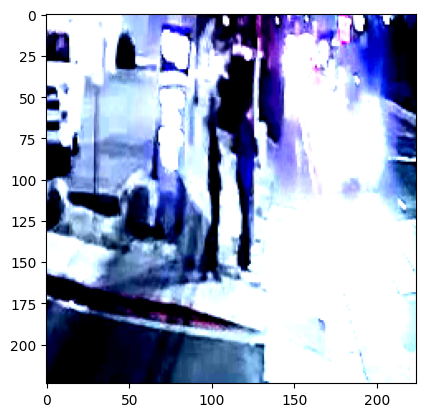

: 

: 

In [5]:
plt.imshow(inputs[0,0].permute(1,2,0).cpu().numpy())
plt.show()

In [8]:
recall_scores

[0.8571428571428571,
 0.6666666666666666,
 0.5238095238095238,
 0.3333333333333333,
 0.23809523809523808,
 0.0,
 0.0,
 0.0]

In [9]:
precision_scores

[0.3,
 0.3888888888888889,
 0.4583333333333333,
 0.5,
 0.8333333333333334,
 nan,
 nan,
 nan]

In [10]:
import random
import torch.nn.functional as F
def random_brightness_adjustment(frames, brightness_factor_range=(0.5, 1.5)):
    adjusted_frames = []
    brightness_factor = random.uniform(*brightness_factor_range)
    for frame in frames:
        frame = F.adjust_brightness(F.to_pil_image(frame.astype(np.uint8)), brightness_factor)
        adjusted_frames.append(np.array(frame))
    return np.stack(adjusted_frames)


In [49]:
class RandomBrightnessAdjustment:
    def __init__(self, brightness_range=(0.5, 1.5)):
        self.brightness_range = brightness_range

    def __call__(self, frames):
        adjusted_frames = []
        brightness_factor = random.uniform(*self.brightness_range)
        for frame in frames:
            frame = F.adjust_brightness(frame, brightness_factor)
            adjusted_frames.append(frame)
        return torch.stack(adjusted_frames)

In [50]:
random_brightness = RandomBrightnessAdjustment()

In [77]:
from torchvision.transforms.functional import adjust_brightness,hflip,adjust_contrast,adjust_saturation,adjust_hue

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8398877..3.3068974].


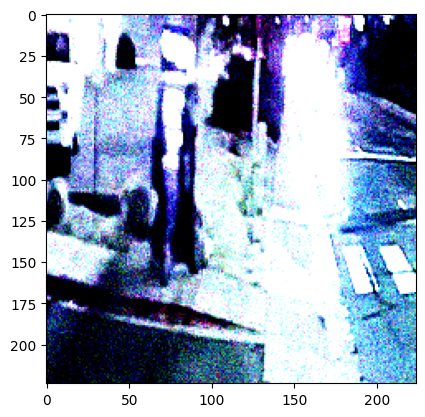

In [20]:
brightness_factor = 0.5
# adjusted_img = adjust_brightness(inputs[0,0], np.random.uniform(1-brightness_factor, 1+brightness_factor))
contrast_factor = 0.5
noise_factor = 0.2
# adjusted_img = adjust_contrast(inputs[0,0], np.random.uniform(1-contrast_factor, 1+contrast_factor))
adjusted_img = inputs[0,0] + torch.randn_like(inputs[0,0]) * noise_factor
# adjusted_img = inputs[0,0]
# adjusted_img = hflip(inputs[0,0])
# adjusted_img = adjust_hue(inputs[0,0],0.2)
# adjusted_img = inputs[0,0] + torch.randn_like(inputs[0,0]) * 0.2
plt.imshow(adjusted_img.permute(1,2,0).cpu().numpy())
plt.show()

In [9]:
precision, recall

(0.7777777777777778, 0.3333333333333333)

In [7]:
precision, recall

(0.6521739130434783, 0.7142857142857143)